In [12]:
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np

In [13]:
class Particle:
    def __init__(self, x, y, vx=0, vy=0):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.best_x = x
        self.best_y = y

In [14]:
def objective_function(x, y):
    return (y - x**2)**2 + (1 - x)**2

In [15]:
def update_velocity(particle, w, c1, c2, global_best):
    r1, r2 = np.random.rand(), np.random.rand()

    inertia = w * np.array([particle.vx, particle.vy])

    cognitive = c1 * r1 * (np.array([particle.best_x, particle.best_y]) - np.array([particle.x, particle.y]))
    social = c2 * r2 * (np.array([global_best.x, global_best.y]) - np.array([particle.x, particle.y]))

    new_velocity = 0.5 * (inertia + cognitive + social)
    
    return new_velocity.tolist()

def update_position(particle, bounds):
    new_x = particle.x + particle.vx
    new_y = particle.y + particle.vy
    new_x = max(bounds[0][0], min(bounds[0][1], new_x))
    new_y = max(bounds[1][0], min(bounds[1][1], new_y))
    return new_x, new_y

In [18]:
class PSOApp:
    def __init__(self, root):
        self.root = root
        self.root.title("PSO Algorithm App")
        self.current_generation = 1
        self.minima = [0, 0, 10**10]

        self.create_widgets()
        self.initialize_plot()

    def create_widgets(self):
        self.label1 = ttk.Label(self.root, text="PSO Algorithm for Function Minimization")
        self.label1.pack(pady=10)

        self.label2 = ttk.Label(self.root, text="Population Size:")
        self.label2.pack()
        self.population_size_entry = ttk.Entry(self.root)
        self.population_size_entry.pack()

        self.label3 = ttk.Label(self.root, text="Number of Generations:")
        self.label3.pack()
        self.num_generations_entry = ttk.Entry(self.root)
        self.num_generations_entry.pack()

        self.label4 = ttk.Label(self.root, text="Inertia Weight (w):")
        self.label4.pack()
        self.w_entry = ttk.Entry(self.root)
        self.w_entry.pack()

        self.label5 = ttk.Label(self.root, text="Cognitive Coefficient (c1):")
        self.label5.pack()
        self.c1_entry = ttk.Entry(self.root)
        self.c1_entry.pack()

        self.label6 = ttk.Label(self.root, text="Social Coefficient (c2):")
        self.label6.pack()
        self.c2_entry = ttk.Entry(self.root)
        self.c2_entry.pack()

        self.start_button = ttk.Button(self.root, text="Start PSO", command=self.run_pso)
        self.start_button.pack(pady=20)

        self.next_button = ttk.Button(self.root, text="Next Iteration", command=self.next_iteration)
        self.next_button.pack(pady=10)
        self.next_button['state'] = 'disabled'

        self.canvas_frame = ttk.Frame(self.root)
        self.canvas_frame.pack()
    
    def initialize_plot(self):
        x_vals = np.linspace(-5, 5, 100)
        y_vals = np.linspace(-5, 5, 100)
        X, Y = np.meshgrid(x_vals, y_vals)
        Z = objective_function(X, Y)

        fig, ax = plt.subplots()
        ax.contour(X, Y, Z, levels=np.logspace(-1, 3, 10))

        self.canvas_frame = ttk.Frame(self.root)
        self.canvas_frame.pack()

        self.canvas = FigureCanvasTkAgg(fig, master=self.canvas_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

    def run_pso(self):
        try:
            population_size = int(self.population_size_entry.get())
            num_generations = int(self.num_generations_entry.get())
            w = float(self.w_entry.get())
            c1 = float(self.c1_entry.get())
            c2 = float(self.c2_entry.get())

            bounds = [(-5, 5), (-5, 5)] 

            self.particles = [Particle(np.random.uniform(bounds[0][0], bounds[0][1]),
                                       np.random.uniform(bounds[1][0], bounds[1][1]))
                              for _ in range(population_size)]

            self.global_best = min(self.particles, key=lambda p: objective_function(p.x, p.y))

            self.num_generations = num_generations

            self.update_plot()

            self.next_button['state'] = 'normal'

        except ValueError:
            tk.messagebox.showerror("Error", "Invalid input. Please enter valid numerical values.")

    def next_iteration(self):
        if self.current_generation < self.num_generations:
            for particle in self.particles:
                velocity = update_velocity(particle, float(self.w_entry.get()), float(self.c1_entry.get()),
                                           float(self.c2_entry.get()), self.global_best)
                particle.vx, particle.vy = velocity
                particle.x, particle.y = update_position(particle, [(-5, 5), (-5, 5)])

                current_fitness = objective_function(particle.x, particle.y)
                if current_fitness < objective_function(particle.best_x, particle.best_y):
                    particle.best_x, particle.best_y = particle.x, particle.y

                if current_fitness < objective_function(self.global_best.x, self.global_best.y):
                    self.global_best = particle

            self.current_generation += 1
            self.update_plot()
        else:
            self.next_button['state'] = 'disabled'

    def update_plot(self):
        x_vals = np.linspace(-5, 5, 100)
        y_vals = np.linspace(-5, 5, 100)
        X, Y = np.meshgrid(x_vals, y_vals)
        Z = objective_function(X, Y)

        fig, ax = plt.subplots()
        ax.contour(X, Y, Z, levels=np.logspace(-1, 3, 10))
        ax.plot(self.global_best.x, self.global_best.y, 'ro', label='Global Minimum', markersize=8)
        ax.text(self.global_best.x, self.global_best.y, f'({self.global_best.x:.15f}, {self.global_best.y:.15f})', color='red', fontsize=8, va='bottom')

        if self.minima[2] > objective_function(self.global_best.x, self.global_best.y):
            self.minima[0] = self.global_best.x
            self.minima[1] = self.global_best.y
            self.minima[2] = objective_function(self.global_best.x, self.global_best.y)

        abs_min_text = f'Minimum: {objective_function(self.minima[0], self.minima[1]):.15f} at {self.minima[0]:.15f}, {self.minima[1]:.15f}'
        ax.text(0.5, -6, abs_min_text, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.7))

        for particle in self.particles:
            ax.plot(particle.x, particle.y, 'bo')

        ax.set_title(f'PSO Iteration {self.current_generation}')
        ax.legend()

        if hasattr(self, 'canvas'):
            self.canvas.get_tk_widget().destroy()

        self.canvas = FigureCanvasTkAgg(fig, master=self.canvas_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)


/var/folders/cb/ngq96v390n94hq3fr4_bt6dw0000gn/T/ipykernel_51031/405881140.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


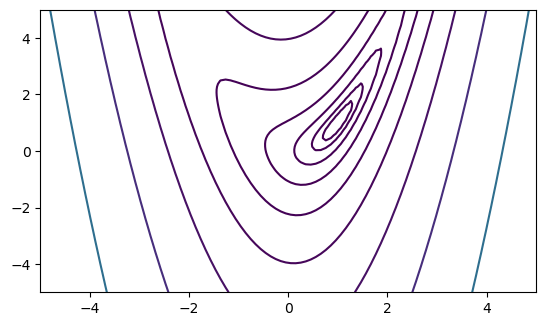

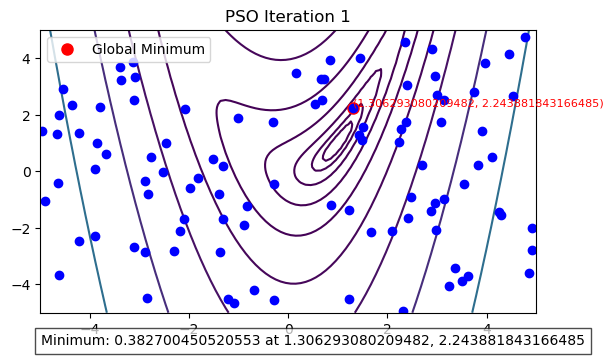

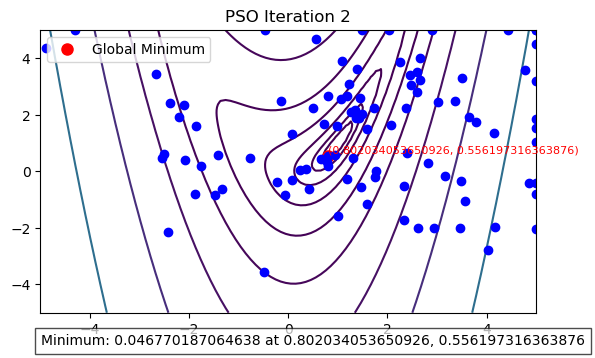

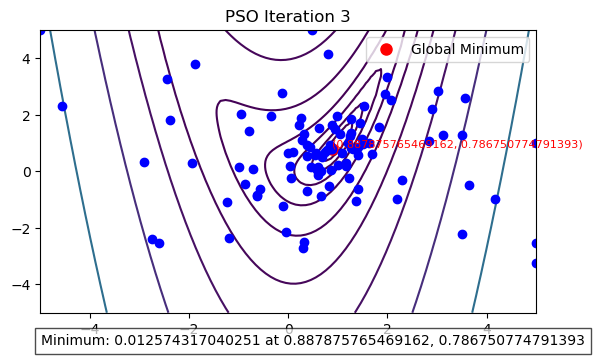

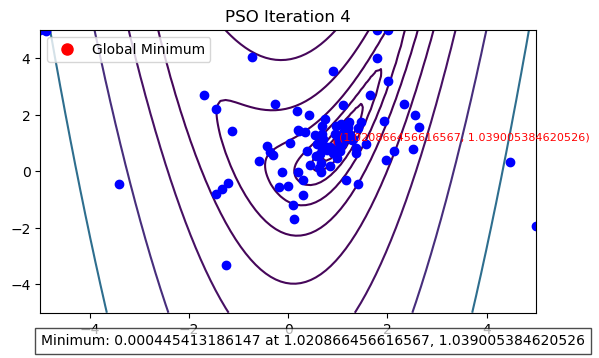

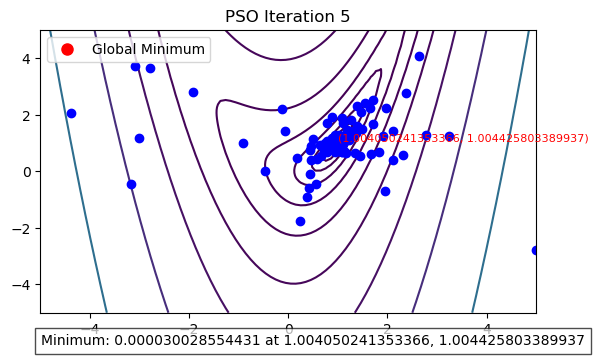

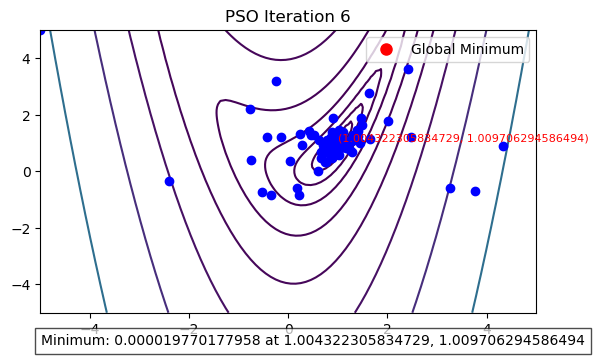

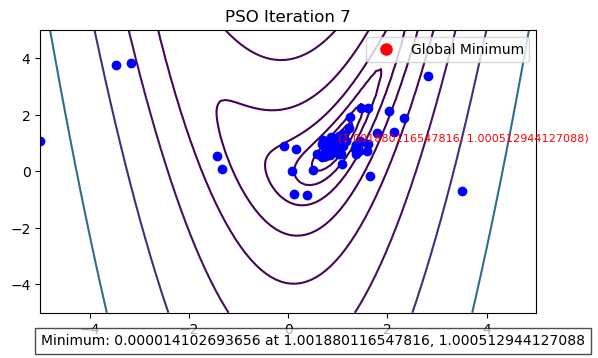

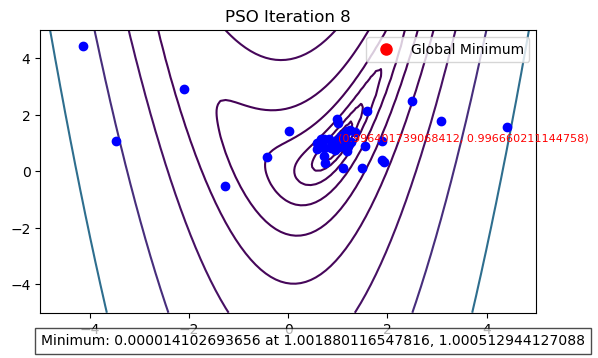

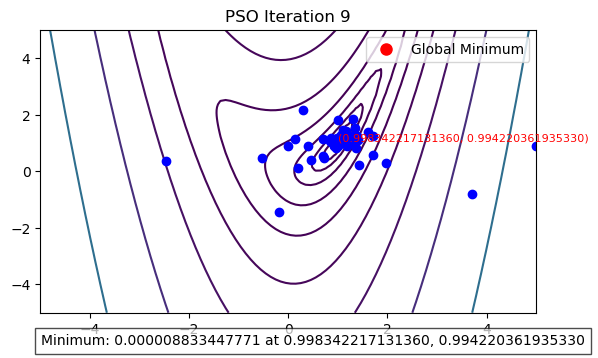

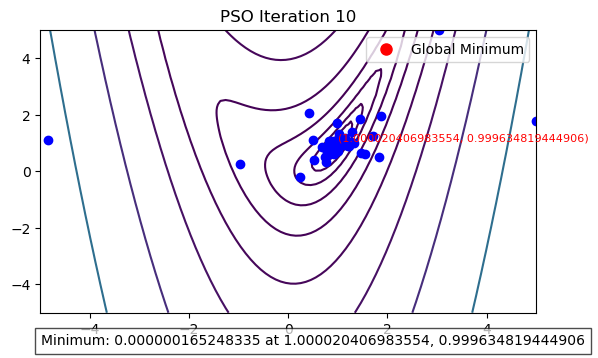

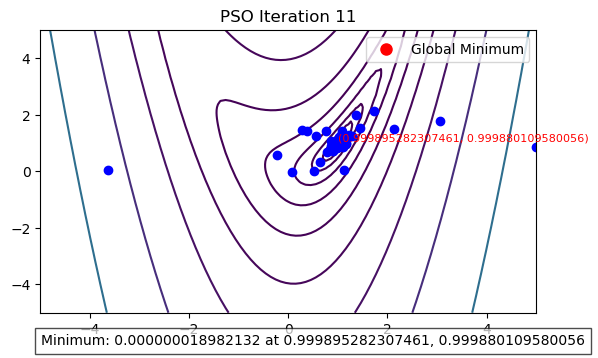

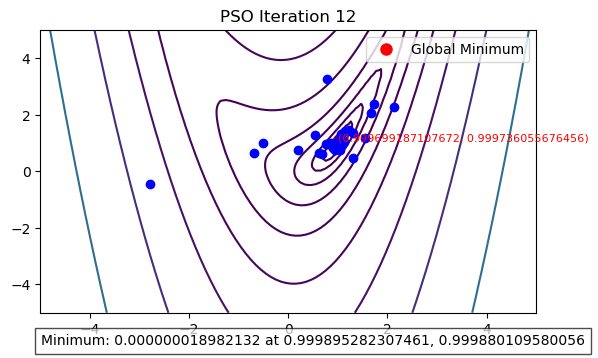

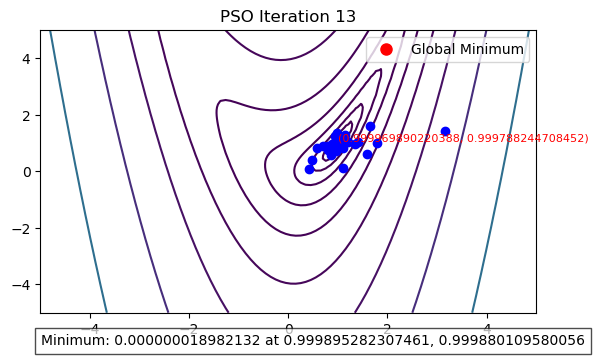

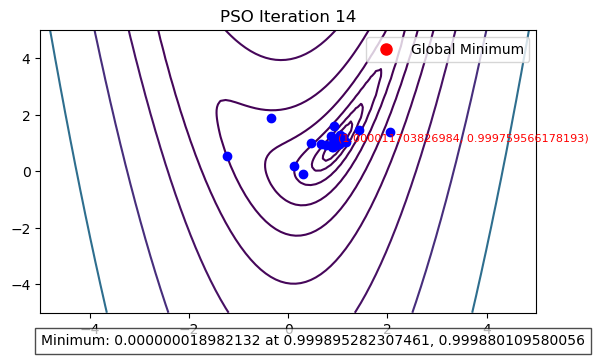

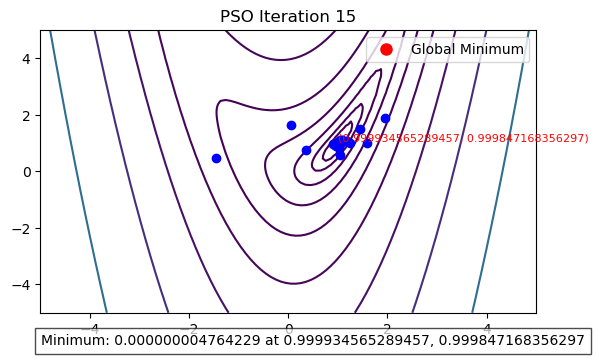

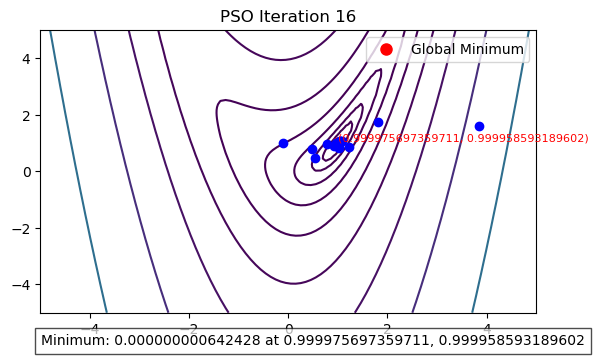

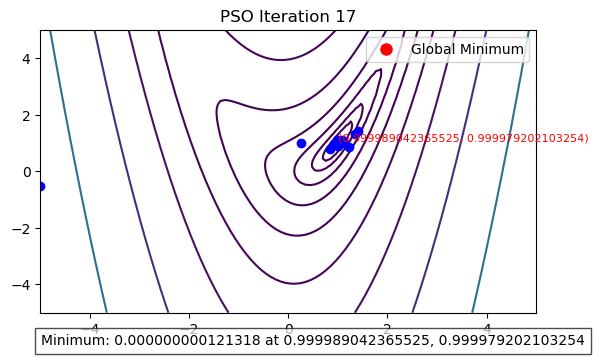

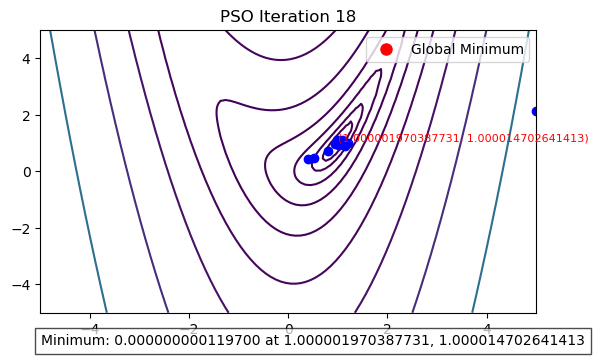

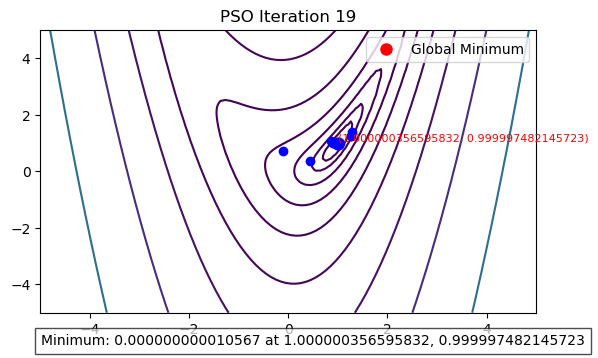

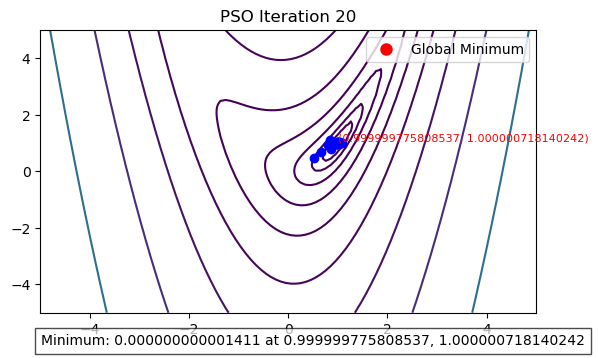

In [23]:
if __name__ == "__main__":
    root = tk.Tk()
    app = PSOApp(root)
    root.mainloop()